Classificação de Dígitos MNIST com CNN

Visão Geral

Este notebook implementa uma **Rede Neural Convolucional (CNN)** para classificação de dígitos manuscritos do dataset MNIST. Utilizamos **Keras com backend PyTorch** para demonstrar conceitos fundamentais de deep learning para visão computacional.

Objetivos:
- Implementar uma CNN eficiente para classificação de imagens
- Explorar técnicas de pré-processamento e visualização de dados
- Analisar métricas de performance e resultados do modelo
- Explicar os conceitos matemáticos por trás das CNNs

Tecnologias:
- **Keras 3.0** (backend PyTorch)
- **NumPy** para manipulação de arrays
- **Matplotlib/Seaborn** para visualizações
- **Scikit-learn** para métricas adicionais


In [71]:
#Configuração do Ambiente
import os
import warnings
warnings.filterwarnings('ignore')

# Configura o backend do Keras para usar PyTorch
os.environ['KERAS_BACKEND'] = 'torch'

# Imports principais
import torch
import keras
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import time

# Configurações de visualização
plt.style.use('default')
sns.set_palette("husl")

# Verificação do ambiente
print("🔧 Configuração do Ambiente:")
print(f"✅ Keras backend: {keras.backend.backend()}")
print(f"✅ PyTorch version: {torch.__version__}")
print(f"✅ Keras version: {keras.__version__}")
print(f"✅ CUDA disponível: {torch.cuda.is_available()}")

if torch.cuda.is_available():
    print(f"🚀 GPU: {torch.cuda.get_device_name(0)}")
else:
    print("💻 Usando CPU")


🔧 Configuração do Ambiente:
✅ Keras backend: torch
✅ PyTorch version: 2.6.0+cpu
✅ Keras version: 3.10.0
✅ CUDA disponível: False
💻 Usando CPU


Carregamento e Exploração dos Dados

O Dataset MNIST

O MNIST (Modified National Institute of Standards and Technology) é um dos datasets mais famosos em machine learning, contendo:

- **60.000 imagens de treino** de dígitos manuscritos (0-9)
- **10.000 imagens de teste**
- **Resolução**: 28x28 pixels em escala de cinza
- **Valores de pixel**: 0-255 (0 = preto, 255 = branco)

Tarefa de Classificação

Estamos lidando com um problema de **classificação multiclasse** onde:
- **Input**: Imagem 28x28 pixels (784 features)
- **Output**: Uma das 10 classes (dígitos 0-9)
- **Função objetivo**: Minimizar a cross-entropy categórica

$$
L(y, \hat{y}) = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

Onde $y$ é o rótulo verdadeiro (one-hot) e $\hat{y}$ é a predição do modelo.


In [72]:
# Carregamento dos Dados
print("Carregando dataset MNIST...")

# Parâmetros
num_classes = 10
input_shape = (28, 28, 1)

# Carregando o dataset
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Informações básicas
print("Informações do Dataset:")
print(f"Treino: {x_train.shape[0]:,} amostras")
print(f"Teste: {x_test.shape[0]:,} amostras")
print(f"Dimensões da imagem: {x_train.shape[1]}x{x_train.shape[2]}")
print(f"Classes: {len(np.unique(y_train))}")
print(f"Tipo original: {x_train.dtype}")
print(f"Range original: [{x_train.min()}, {x_train.max()}]")

# Backup dos labels originais para análise
y_train_original = y_train.copy()
y_test_original = y_test.copy()

Carregando dataset MNIST...
Informações do Dataset:
Treino: 60,000 amostras
Teste: 10,000 amostras
Dimensões da imagem: 28x28
Classes: 10
Tipo original: uint8
Range original: [0, 255]


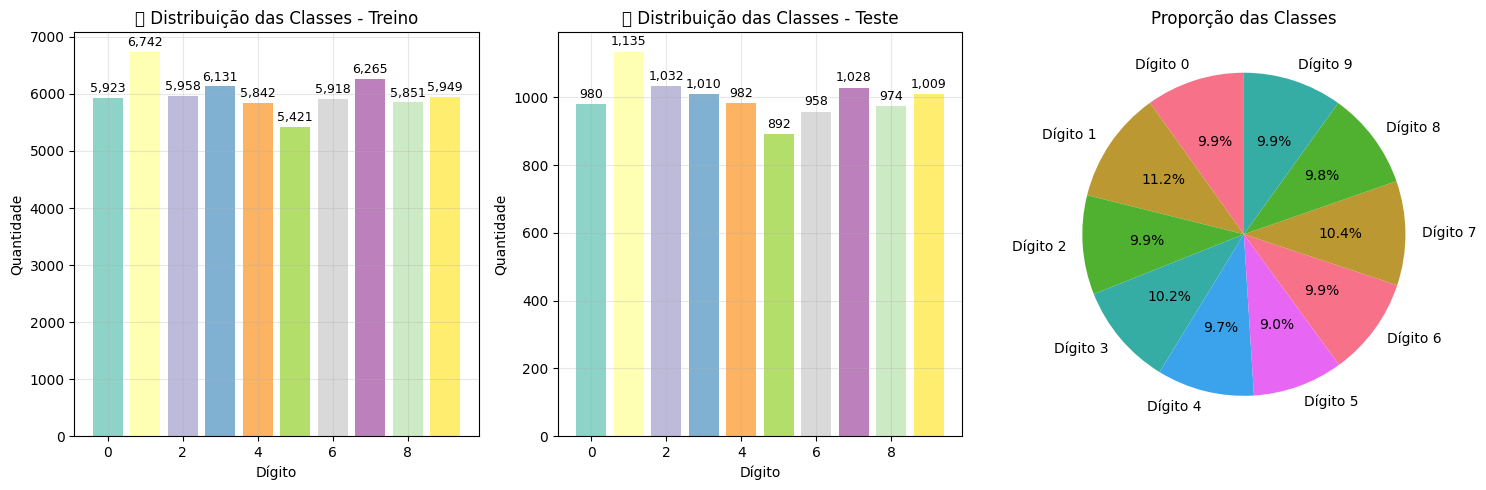

Estatísticas do Dataset:
• Dataset está balanceado: False
• Desvio padrão das contagens: 322.08
• Classe mais frequente: 1 (6,742 amostras)
• Classe menos frequente: 5 (5,421 amostras)


In [74]:
# Análise Exploratória dos Dados

# 1. Distribuição das classes
plt.figure(figsize=(15, 5))

# Subplot 1: Distribuição de treino
plt.subplot(1, 3, 1)
unique_train, counts_train = np.unique(y_train_original, return_counts=True)
bars = plt.bar(unique_train, counts_train, color=plt.cm.Set3(np.linspace(0, 1, 10)))
plt.title('📊 Distribuição das Classes - Treino')
plt.xlabel('Dígito')
plt.ylabel('Quantidade')
plt.grid(True, alpha=0.3)

# Adicionar valores nas barras
for bar, count in zip(bars, counts_train):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count:,}', ha='center', va='bottom', fontsize=9)

# Subplot 2: Distribuição de teste
plt.subplot(1, 3, 2)
unique_test, counts_test = np.unique(y_test_original, return_counts=True)
bars = plt.bar(unique_test, counts_test, color=plt.cm.Set3(np.linspace(0, 1, 10)))
plt.title('📊 Distribuição das Classes - Teste')
plt.xlabel('Dígito')
plt.ylabel('Quantidade')
plt.grid(True, alpha=0.3)

for bar, count in zip(bars, counts_test):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 10, 
             f'{count:,}', ha='center', va='bottom', fontsize=9)

# Subplot 3: Proporção das classes
plt.subplot(1, 3, 3)
proportions = counts_train / counts_train.sum()
plt.pie(proportions, labels=[f'Dígito {i}' for i in unique_train], 
        autopct='%1.1f%%', startangle=90)
plt.title('Proporção das Classes')

plt.tight_layout()
plt.show()

# Estatísticas
print("Estatísticas do Dataset:")
print(f"• Dataset está balanceado: {np.std(counts_train) < 300}")
print(f"• Desvio padrão das contagens: {np.std(counts_train):.2f}")
print(f"• Classe mais frequente: {unique_train[np.argmax(counts_train)]} ({counts_train.max():,} amostras)")
print(f"• Classe menos frequente: {unique_train[np.argmin(counts_train)]} ({counts_train.min():,} amostras)")


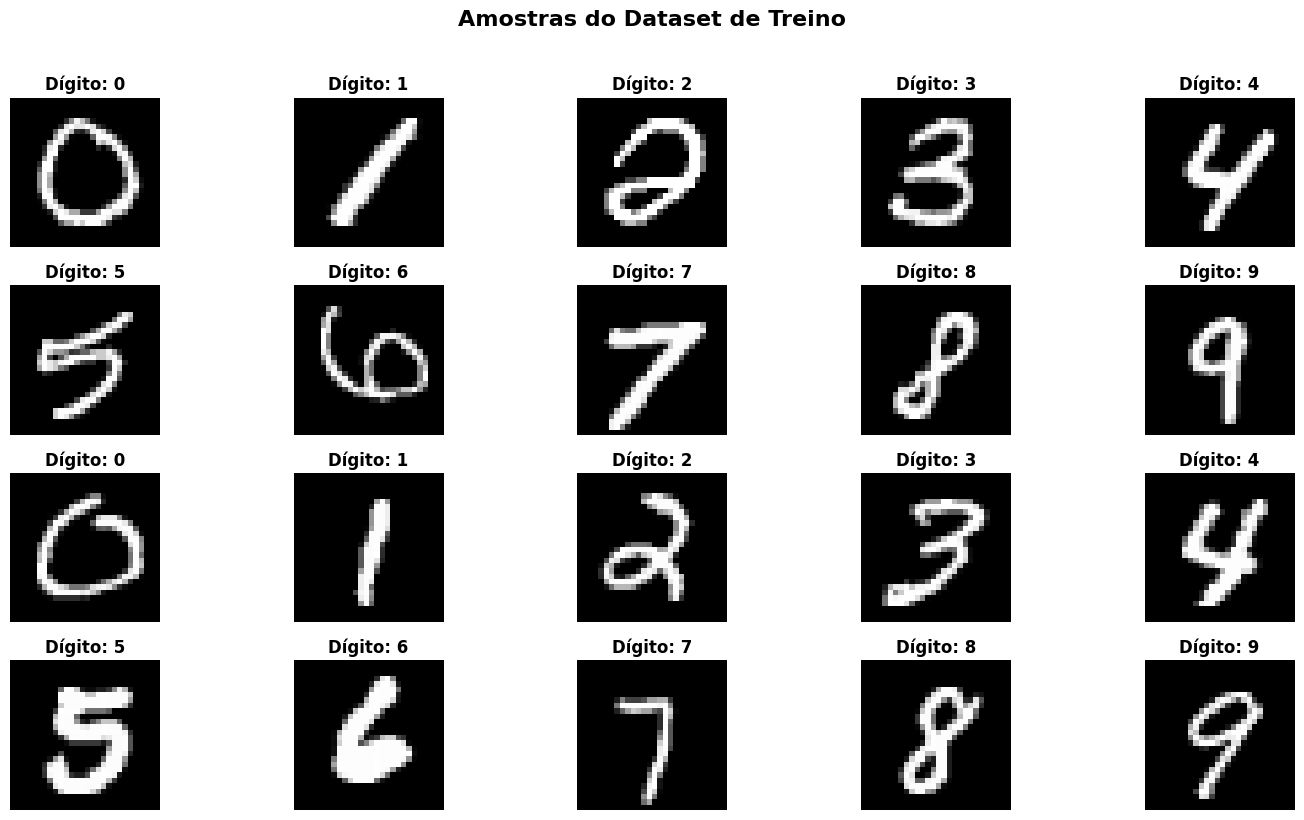

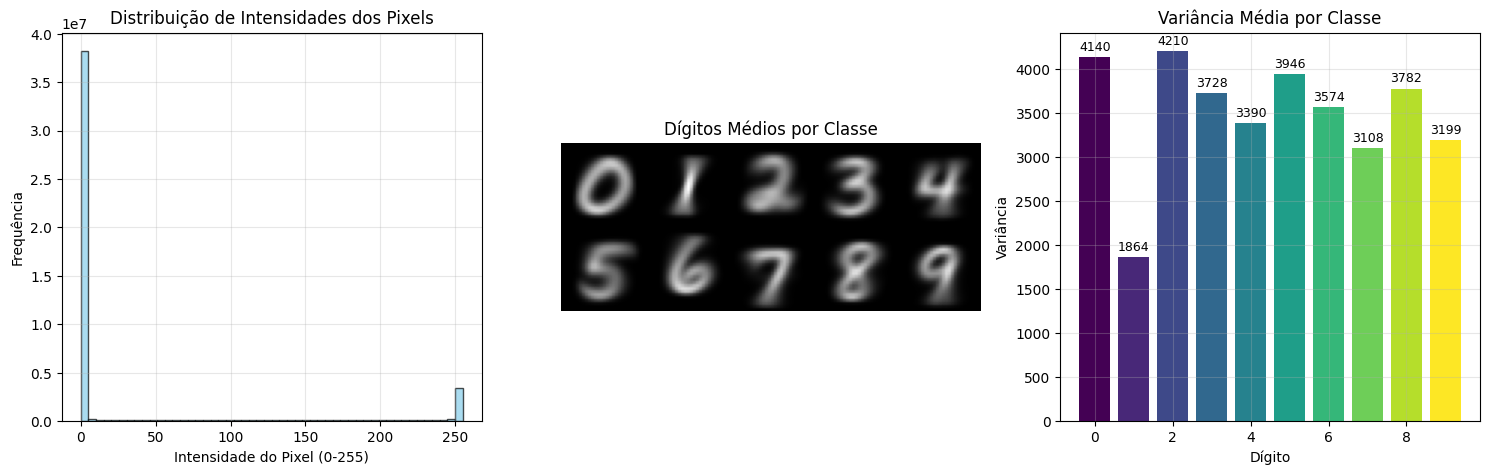

Insights dos Dados:
• Intensidade média geral: 33.32
• Desvio padrão da intensidade: 78.57
• Dígito com maior variância: 2 (var=4210)
• Dígito com menor variância: 1 (var=1864)


In [75]:
# Visualização de Amostras

def plot_sample_images(x_data, y_data, title, num_samples=20):
    """Plota amostras do dataset com seus rótulos"""
    plt.figure(figsize=(15, 8))
    
    # Grid 4x5 para 20 amostras
    rows, cols = 4, 5
    
    for i in range(num_samples):
        plt.subplot(rows, cols, i + 1)
        
        # Escolher uma amostra aleatória de cada classe
        class_idx = i % 10
        samples_of_class = np.where(y_data == class_idx)[0]
        random_sample = np.random.choice(samples_of_class)
        
        plt.imshow(x_data[random_sample], cmap='gray')
        plt.title(f'Dígito: {y_data[random_sample]}', fontsize=12, fontweight='bold')
        plt.axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()

# Mostrar amostras do conjunto de treino
plot_sample_images(x_train, y_train_original, 'Amostras do Dataset de Treino')

# Análise da intensidade dos pixels
plt.figure(figsize=(15, 5))

# Subplot 1: Histograma de intensidades
plt.subplot(1, 3, 1)
pixel_values = x_train.flatten()
plt.hist(pixel_values, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
plt.title('Distribuição de Intensidades dos Pixels')
plt.xlabel('Intensidade do Pixel (0-255)')
plt.ylabel('Frequência')
plt.grid(True, alpha=0.3)

# Subplot 2: Pixel médio por classe
plt.subplot(1, 3, 2)
mean_images = []
for digit in range(10):
    digit_images = x_train[y_train_original == digit]
    mean_image = np.mean(digit_images, axis=0)
    mean_images.append(mean_image)

# Criar uma grade com as imagens médias
mean_grid = np.concatenate([np.concatenate(mean_images[i:i+5], axis=1) 
                           for i in range(0, 10, 5)], axis=0)
plt.imshow(mean_grid, cmap='gray')
plt.title('Dígitos Médios por Classe')
plt.axis('off')

# Subplot 3: Variância por classe
plt.subplot(1, 3, 3)
variances = []
for digit in range(10):
    digit_images = x_train[y_train_original == digit]
    variance = np.var(digit_images, axis=0).mean()
    variances.append(variance)

bars = plt.bar(range(10), variances, color=plt.cm.viridis(np.linspace(0, 1, 10)))
plt.title('Variância Média por Classe')
plt.xlabel('Dígito')
plt.ylabel('Variância')
plt.grid(True, alpha=0.3)

# Adicionar valores nas barras
for i, (bar, var) in enumerate(zip(bars, variances)):
    plt.text(i, var + max(variances)*0.01, f'{var:.0f}', 
             ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

print("Insights dos Dados:")
print(f"• Intensidade média geral: {pixel_values.mean():.2f}")
print(f"• Desvio padrão da intensidade: {pixel_values.std():.2f}")
print(f"• Dígito com maior variância: {np.argmax(variances)} (var={max(variances):.0f})")
print(f"• Dígito com menor variância: {np.argmin(variances)} (var={min(variances):.0f})")


Pré-processamento dos Dados

Transformações Aplicadas

1. **Normalização dos Pixels**
Convertemos os valores de pixel de `[0, 255]` para `[0, 1]`:

$$
x_{normalizado} = \frac{x_{original}}{255}
$$

**Vantagens:**
- **Convergência mais rápida**: Gradientes mais estáveis
- **Estabilidade numérica**: Evita overflow/underflow
- **Ativações balanceadas**: Mantém as ativações em ranges adequados

2. **Reshape para CNN**
Adicionamos uma dimensão de canal para compatibilidade com CNNs:
- **De**: `(samples, 28, 28)` 
- **Para**: `(samples, 28, 28, 1)`

3. **Codificação One-Hot dos Labels**
Convertemos labels categóricos para vetores binários:

$$
y_{one-hot}[i] = \begin{cases} 
1 & \text{se } i = \text{classe verdadeira} \\
0 & \text{caso contrário}
\end{cases}
$$

**Exemplo**: Label `3` → `[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]`


 Aplicando transformações...
Antes da normalização:
  Min: 0, Max: 255, Tipo: uint8
Após normalização:
  Min: 0.000, Max: 1.000, Tipo: float32

Antes do reshape: (60000, 28, 28)
Após reshape: (60000, 28, 28, 1)

Labels antes do one-hot: [5 0 4 1 9] (tipo: <class 'numpy.uint8'>)
Labels após one-hot: [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] (shape: (10,))


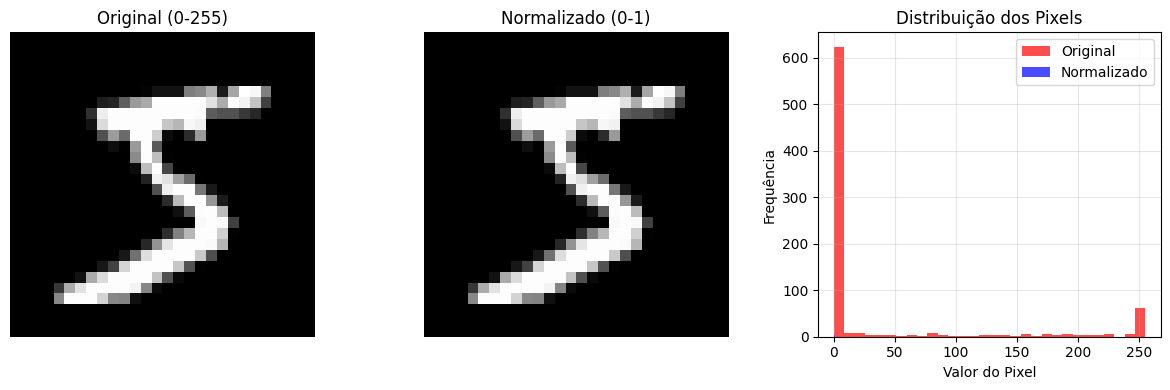

 Pré-processamento concluído!
Shapes finais:
  X_train: (60000, 28, 28, 1)
  y_train: (60000, 10)
  X_test: (10000, 28, 28, 1)
  y_test: (10000, 10)


In [76]:
# Aplicando o Pré-processamento

print(" Aplicando transformações...")

# 1. Normalização (0-255 → 0-1)
print("Antes da normalização:")
print(f"  Min: {x_train.min()}, Max: {x_train.max()}, Tipo: {x_train.dtype}")

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

print("Após normalização:")
print(f"  Min: {x_train.min():.3f}, Max: {x_train.max():.3f}, Tipo: {x_train.dtype}")

# 2. Reshape para CNN (adicionar dimensão do canal)
print(f"\nAntes do reshape: {x_train.shape}")
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print(f"Após reshape: {x_train.shape}")

# 3. One-hot encoding dos labels
print(f"\nLabels antes do one-hot: {y_train[:5]} (tipo: {type(y_train[0])})")
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)
print(f"Labels após one-hot: {y_train_categorical[0]} (shape: {y_train_categorical[0].shape})")

# Visualização do efeito da normalização
plt.figure(figsize=(12, 4))

# Antes da normalização (usando dados originais)
(x_orig, _), _ = keras.datasets.mnist.load_data()
plt.subplot(1, 3, 1)
plt.imshow(x_orig[0], cmap='gray')
plt.title('Original (0-255)')
plt.axis('off')

# Após normalização
plt.subplot(1, 3, 2)
plt.imshow(x_train[0, :, :, 0], cmap='gray')
plt.title('Normalizado (0-1)')
plt.axis('off')

# Histograma comparativo
plt.subplot(1, 3, 3)
plt.hist(x_orig[0].flatten(), bins=30, alpha=0.7, label='Original', color='red')
plt.hist(x_train[0, :, :, 0].flatten(), bins=30, alpha=0.7, label='Normalizado', color='blue')
plt.title('Distribuição dos Pixels')
plt.xlabel('Valor do Pixel')
plt.ylabel('Frequência')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(" Pré-processamento concluído!")
print(f"Shapes finais:")
print(f"  X_train: {x_train.shape}")
print(f"  y_train: {y_train_categorical.shape}")
print(f"  X_test: {x_test.shape}")
print(f"  y_test: {y_test_categorical.shape}")


Arquitetura da Rede Neural Convolucional

Fundamentos Matemáticos das CNNs

**Operação de Convolução**

A convolução é a operação fundamental das CNNs, definida matematicamente como:

$$
(f * g)(x, y) = \sum_{i=-\infty}^{\infty} \sum_{j=-\infty}^{\infty} f(i, j) \cdot g(x-i, y-j)
$$

Para uma imagem `I` e filtro `K`, a convolução é:

$$
S(i,j) = (I * K)(i,j) = \sum_m \sum_n I(m,n) \cdot K(i-m, j-n)
$$

**Dimensões das Camadas**

**Camada Convolucional:**
$$
Output_{height} = \frac{Input_{height} - Kernel_{height} + 2 \times Padding}{Stride} + 1
$$

**Max Pooling:**
- Reduz dimensionalidade mantendo características importantes
- Invariância a pequenas translações
- Reduz overfitting

**Nossa Arquitetura**

```
Input (28x28x1)
    ↓
Conv2D (32 filters, 3x3) → ReLU → (26x26x32)
    ↓
MaxPooling2D (2x2) → (13x13x32)
    ↓
Conv2D (64 filters, 3x3) → ReLU → (11x11x64)
    ↓
MaxPooling2D (2x2) → (5x5x64)
    ↓
Flatten → (1600)
    ↓
Dropout (50%) → (1600)
    ↓
Dense (10) → Softmax → (10)
```

**Função de Ativação Softmax**

$$
\text{softmax}(z_i) = \frac{e^{z_i}}{\sum_{j=1}^{K} e^{z_j}}
$$

Garante que a saída seja uma distribuição de probabilidade: $\sum_{i=1}^{K} p_i = 1$


In [77]:
# Construção do Modelo CNN

from keras import layers, Model
import keras

print("Construindo a arquitetura CNN...")

# Definição da arquitetura
model = keras.Sequential([
    # Camada de entrada
    keras.Input(shape=input_shape, name='input_layer'),
    
    # Primeiro bloco convolucional
    layers.Conv2D(32, kernel_size=(3, 3), 
                 activation='relu', 
                 name='conv2d_1',
                 kernel_initializer='he_normal'),
    layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_1'),
    
    # Segundo bloco convolucional  
    layers.Conv2D(64, kernel_size=(3, 3), 
                 activation='relu',
                 name='conv2d_2', 
                 kernel_initializer='he_normal'),
    layers.MaxPooling2D(pool_size=(2, 2), name='maxpool_2'),
    
    # Flatten e camadas densas
    layers.Flatten(name='flatten'),
    layers.Dropout(0.5, name='dropout'),
    layers.Dense(num_classes, 
                activation='softmax', 
                name='output',
                kernel_initializer='glorot_uniform'),
])

# Resumo da arquitetura
print("Resumo da Arquitetura:")
model.summary()

# Contagem de parâmetros
total_params = model.count_params()
print(f"\nAnálise de Parâmetros:")
print(f"• Total de parâmetros: {total_params:,}")
print(f"• Parâmetros treináveis: {total_params:,}")
print(f"• Tamanho aproximado do modelo: {total_params * 4 / 1024:.2f} KB (float32)")

# Análise por camada
print(f"\nAnálise por Camada:")
for i, layer in enumerate(model.layers):
    if hasattr(layer, 'count_params'):
        params = layer.count_params()
        print(f"• {layer.name}: {params:,} parâmetros")

Construindo a arquitetura CNN...
Resumo da Arquitetura:


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_1 (MaxPooling2D)        │ (None, 13, 13, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 11, 11, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool_2 (MaxPooling2D)        │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1600)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │        16,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,826 (136.04 KB)

 Trainable params: 34,826 (136.04 KB)

 Non-trainable params: 0 (0.00 B)


Análise de Parâmetros:
• Total de parâmetros: 34,826
• Parâmetros treináveis: 34,826
• Tamanho aproximado do modelo: 136.04 KB (float32)

Análise por Camada:
• conv2d_1: 320 parâmetros
• maxpool_1: 0 parâmetros
• conv2d_2: 18,496 parâmetros
• maxpool_2: 0 parâmetros
• flatten: 0 parâmetros
• dropout: 0 parâmetros
• output: 16,010 parâmetros


You must install pydot (`pip install pydot`) for `plot_model` to work.


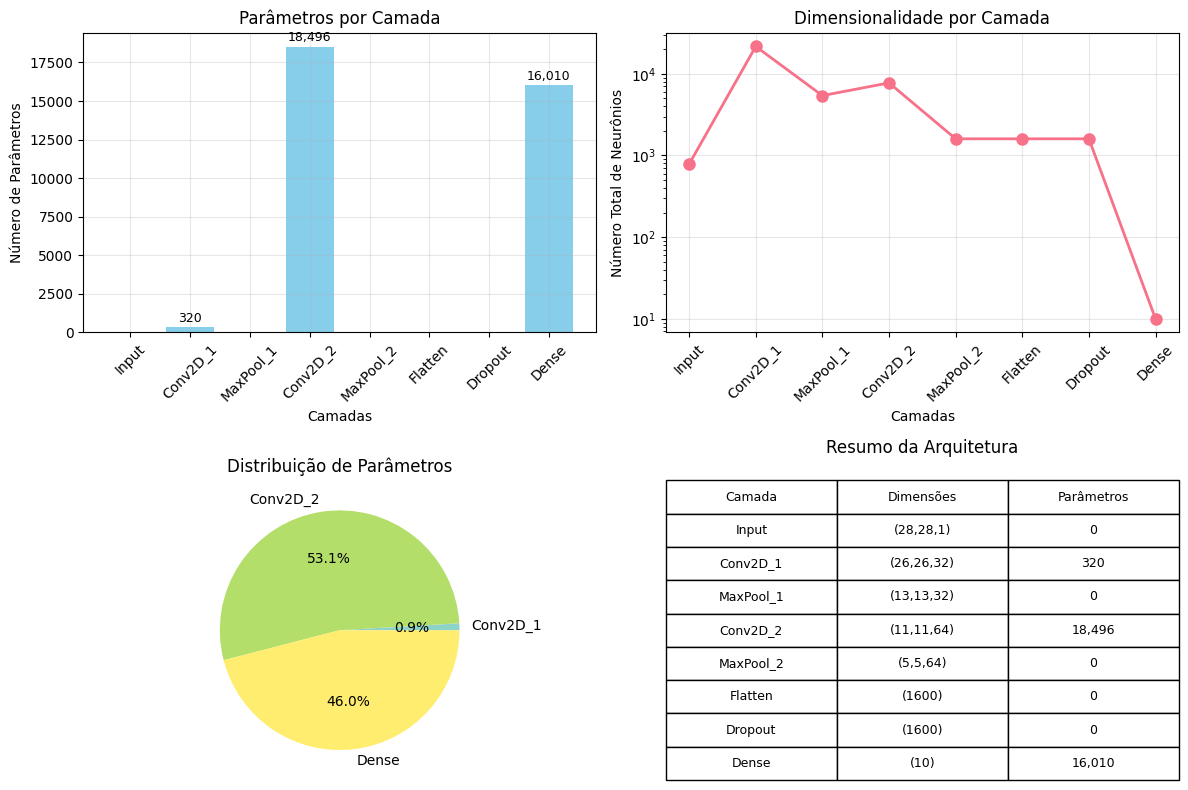

Justificativas da Arquitetura:
• Conv2D com 32/64 filtros: Detecta características básicas → complexas
• Kernel 3x3: Boa relação entre capacidade expressiva e eficiência
• MaxPooling 2x2: Reduz dimensionalidade e aumenta campo receptivo
• Dropout 50%: Regularização para evitar overfitting
• Softmax final: Saída em formato de probabilidades


In [78]:
# Visualização da Arquitetura

# Criar um diagrama visual da arquitetura
keras.utils.plot_model(
    model, 
    to_file='model_architecture.png',
    show_shapes=True, 
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=150
)

# Como alternativa, vamos criar uma visualização customizada
plt.figure(figsize=(12, 8))

# Dados para visualização das dimensões
layer_names = ['Input', 'Conv2D_1', 'MaxPool_1', 'Conv2D_2', 'MaxPool_2', 'Flatten', 'Dropout', 'Dense']
dimensions = ['(28,28,1)', '(26,26,32)', '(13,13,32)', '(11,11,64)', '(5,5,64)', '(1600)', '(1600)', '(10)']
param_counts = [0, 320, 0, 18496, 0, 0, 0, 16010]

# Criar visualização em barras dos parâmetros
plt.subplot(2, 2, 1)
colors = ['skyblue' if p > 0 else 'lightgray' for p in param_counts]
bars = plt.bar(range(len(layer_names)), param_counts, color=colors)
plt.title('Parâmetros por Camada')
plt.xlabel('Camadas')
plt.ylabel('Número de Parâmetros')
plt.xticks(range(len(layer_names)), layer_names, rotation=45)
plt.grid(True, alpha=0.3)

# Adicionar valores nas barras
for i, (bar, count) in enumerate(zip(bars, param_counts)):
    if count > 0:
        plt.text(i, count + max(param_counts)*0.01, f'{count:,}', 
                ha='center', va='bottom', fontsize=9)

# Visualização das dimensões
plt.subplot(2, 2, 2)
dimension_values = [28*28*1, 26*26*32, 13*13*32, 11*11*64, 5*5*64, 1600, 1600, 10]
plt.plot(range(len(layer_names)), dimension_values, 'o-', linewidth=2, markersize=8)
plt.title('Dimensionalidade por Camada')
plt.xlabel('Camadas')
plt.ylabel('Número Total de Neurônios')
plt.xticks(range(len(layer_names)), layer_names, rotation=45)
plt.yscale('log')
plt.grid(True, alpha=0.3)

# Proporção de parâmetros
plt.subplot(2, 2, 3)
param_types = ['Conv2D_1', 'Conv2D_2', 'Dense']
param_values = [320, 18496, 16010]
colors = plt.cm.Set3(np.linspace(0, 1, len(param_types)))
plt.pie(param_values, labels=param_types, autopct='%1.1f%%', colors=colors)
plt.title('Distribuição de Parâmetros')

# Tabela de resumo
plt.subplot(2, 2, 4)
plt.axis('off')
table_data = []
for i, (name, dim, params) in enumerate(zip(layer_names, dimensions, param_counts)):
    table_data.append([name, dim, f'{params:,}' if params > 0 else '0'])

table = plt.table(cellText=table_data,
                 colLabels=['Camada', 'Dimensões', 'Parâmetros'],
                 cellLoc='center',
                 loc='center',
                 bbox=[0, 0, 1, 1])
table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 1.5)
plt.title('Resumo da Arquitetura', pad=20)

plt.tight_layout()
plt.show()

print("Justificativas da Arquitetura:")
print("• Conv2D com 32/64 filtros: Detecta características básicas → complexas")
print("• Kernel 3x3: Boa relação entre capacidade expressiva e eficiência")
print("• MaxPooling 2x2: Reduz dimensionalidade e aumenta campo receptivo")
print("• Dropout 50%: Regularização para evitar overfitting")
print("• Softmax final: Saída em formato de probabilidades")


Configuração do Treinamento

Função de Loss: Categorical Crossentropy

Para problemas de classificação multiclasse, usamos a **categorical crossentropy**:

$$
L = -\frac{1}{N} \sum_{i=1}^{N} \sum_{c=1}^{C} y_{i,c} \log(\hat{y}_{i,c})
$$

Onde:
- $N$ = número de amostras
- $C$ = número de classes
- $y_{i,c}$ = rótulo verdadeiro (one-hot)
- $\hat{y}_{i,c}$ = probabilidade predita

Otimizador: Adam

O algoritmo **Adam** combina as vantagens do RMSprop e Momentum:

$$
m_t = \beta_1 m_{t-1} + (1-\beta_1) g_t
$$

$$
v_t = \beta_2 v_{t-1} + (1-\beta_2) g_t^2
$$

$$
\hat{m}_t = \frac{m_t}{1-\beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1-\beta_2^t}
$$

$$
\theta_{t+1} = \theta_t - \frac{\alpha}{\sqrt{\hat{v}_t} + \epsilon} \hat{m}_t
$$

**Vantagens do Adam:**
- Adaptação automática da taxa de aprendizado
- Funciona bem com gradientes esparsos
- Requer menos tuning de hiperparâmetros


In [80]:
# Compilação e Treinamento do Modelo

# Parâmetros de treinamento
batch_size = 128
epochs = 15
validation_split = 0.1

print("Configurando o modelo...")

# Compilação do modelo
model.compile(
    loss="categorical_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    metrics=[
        "accuracy",
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.F1Score(name='f1_score')
    ]
)

# Callbacks para melhorar o treinamento
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

callbacks = [
    # Para Learning Rate
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        verbose=1,
        min_lr=1e-7
    ),
    
    # Early Stopping
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        verbose=1,
        restore_best_weights=True
    ),
    
]

print("Iniciando treinamento...")
print(f"Configurações:")
print(f"  • Batch size: {batch_size}")
print(f"  • Épocas: {epochs}")
print(f"  • Validation split: {validation_split*100}%")
print(f"  • Amostras de treino: {len(x_train) * (1-validation_split):,.0f}")
print(f"  • Amostras de validação: {len(x_train) * validation_split:,.0f}")

# Medir tempo de treinamento
start_time = time.time()

# Treinamento
history = model.fit(
    x_train, y_train_categorical,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=validation_split,
    callbacks=callbacks,
    verbose=1
)

# Tempo total
training_time = time.time() - start_time
print(f"\nTreinamento concluído em {training_time:.2f} segundos!")
print(f"Tempo médio por época: {training_time/epochs:.2f} segundos")

Configurando o modelo...
Iniciando treinamento...
Configurações:
  • Batch size: 128
  • Épocas: 15
  • Validation split: 10.0%
  • Amostras de treino: 54,000
  • Amostras de validação: 6,000
Epoch 1/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9481 - f1_score: 0.9475 - loss: 0.1733 - precision: 0.9591 - recall: 0.9364 - val_accuracy: 0.9855 - val_f1_score: 0.9855 - val_loss: 0.0507 - val_precision: 0.9876 - val_recall: 0.9833 - learning_rate: 0.0010
Epoch 2/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9724 - f1_score: 0.9721 - loss: 0.0850 - precision: 0.9762 - recall: 0.9693 - val_accuracy: 0.9895 - val_f1_score: 0.9894 - val_loss: 0.0394 - val_precision: 0.9906 - val_recall: 0.9878 - learning_rate: 0.0010
Epoch 3/15
422/422 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - accuracy: 0.9807 - f1_score: 0.9806 - loss: 0.0623 - precision: 0.9829 - recall: 0.9786 - val_accuracy: 0.9897 - val_f1_score: 0.9896 - val_loss: 0.0348 - val_precision: 0.9911 - val_recall: 0.988

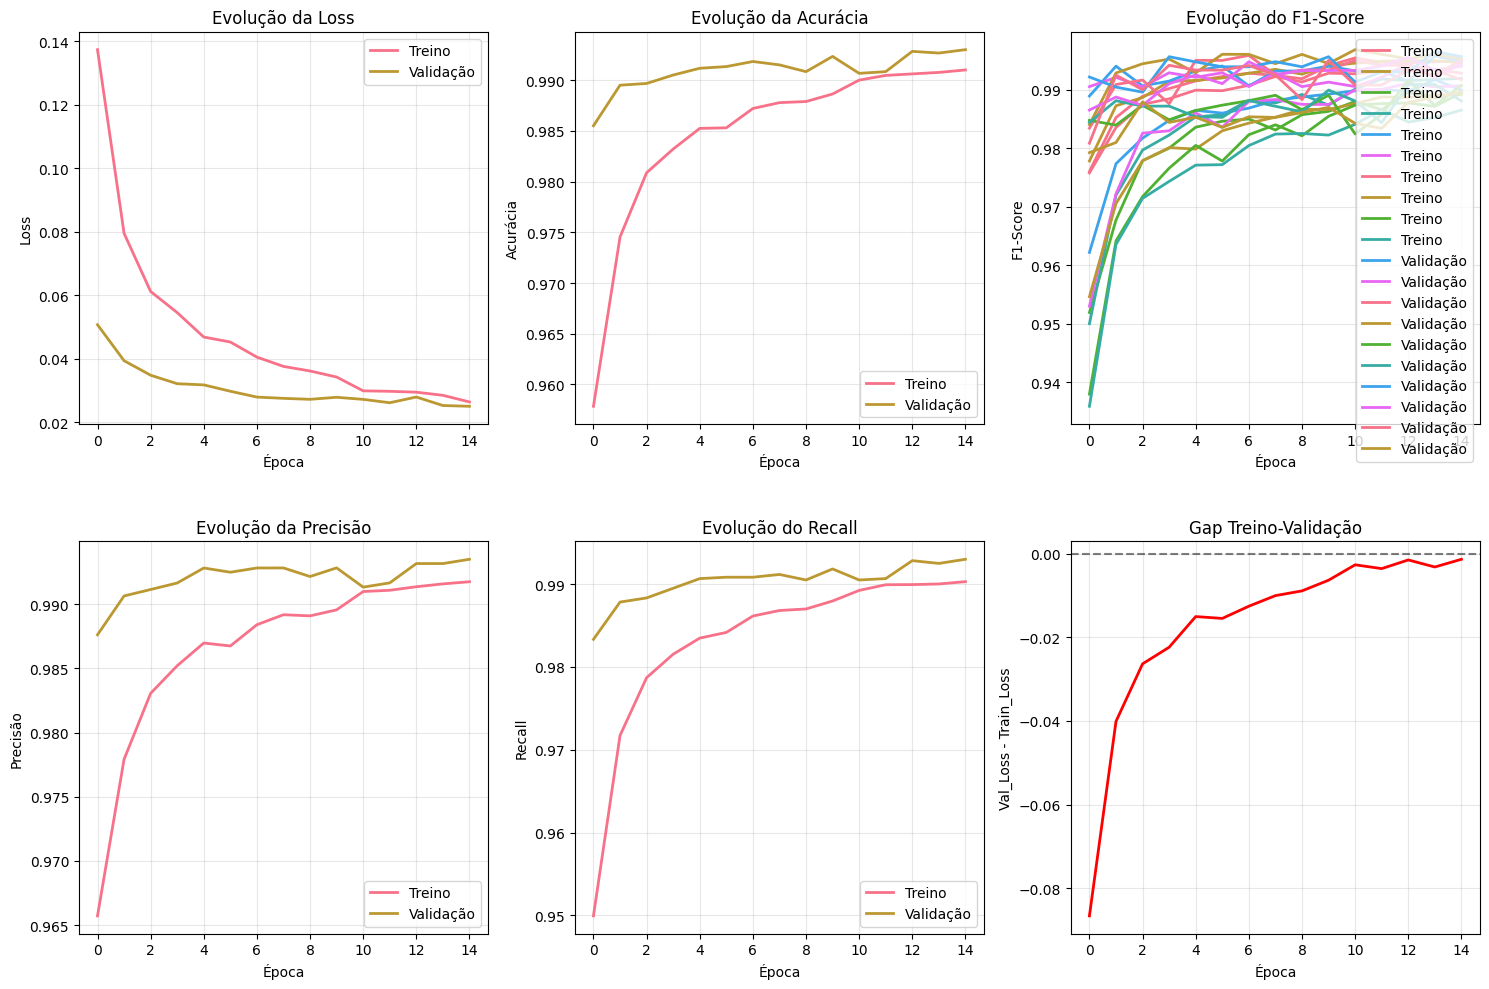

Métricas Finais do Treinamento:
  • Loss Treino: 0.026375779882073402
  • Loss Validação: 0.025009440258145332
  • Acurácia Treino: 0.9909999966621399
  • Acurácia Validação: 0.9929999709129333
  • F1-Score Validação: tensor([0.9949, 0.9944, 0.9917, 0.9952, 0.9907, 0.9881, 0.9956, 0.9940, 0.9950,
        0.9896])

Análise de Overfitting:
  • Loss mínima na validação: 0.0250
  • Loss final na validação: 0.0250
  • Overfitting detectado: ✅ Não


In [81]:
# Análise do Treinamento

# Plotar curvas de treinamento
plt.figure(figsize=(15, 10))

# Loss
plt.subplot(2, 3, 1)
plt.plot(history.history['loss'], label='Treino', linewidth=2)
plt.plot(history.history['val_loss'], label='Validação', linewidth=2)
plt.title('Evolução da Loss')
plt.xlabel('Época')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, alpha=0.3)

# Accuracy
plt.subplot(2, 3, 2)
plt.plot(history.history['accuracy'], label='Treino', linewidth=2)
plt.plot(history.history['val_accuracy'], label='Validação', linewidth=2)
plt.title('Evolução da Acurácia')
plt.xlabel('Época')
plt.ylabel('Acurácia')
plt.legend()
plt.grid(True, alpha=0.3)

# F1 Score
plt.subplot(2, 3, 3)
plt.plot(history.history['f1_score'], label='Treino', linewidth=2)
plt.plot(history.history['val_f1_score'], label='Validação', linewidth=2)
plt.title('Evolução do F1-Score')
plt.xlabel('Época')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True, alpha=0.3)

# Precision
plt.subplot(2, 3, 4)
plt.plot(history.history['precision'], label='Treino', linewidth=2)
plt.plot(history.history['val_precision'], label='Validação', linewidth=2)
plt.title('Evolução da Precisão')
plt.xlabel('Época')
plt.ylabel('Precisão')
plt.legend()
plt.grid(True, alpha=0.3)

# Recall
plt.subplot(2, 3, 5)
plt.plot(history.history['recall'], label='Treino', linewidth=2)
plt.plot(history.history['val_recall'], label='Validação', linewidth=2)
plt.title('Evolução do Recall')
plt.xlabel('Época')
plt.ylabel('Recall')
plt.legend()
plt.grid(True, alpha=0.3)

# Learning Rate (se disponível)
plt.subplot(2, 3, 6)
if 'lr' in history.history:
    plt.plot(history.history['lr'], linewidth=2, color='orange')
    plt.title('Taxa de Aprendizado')
    plt.xlabel('Época')
    plt.ylabel('Learning Rate')
    plt.yscale('log')
else:
    # Análise de overfitting
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    gap = [val - train for val, train in zip(val_loss, train_loss)]
    plt.plot(gap, linewidth=2, color='red')
    plt.title('Gap Treino-Validação')
    plt.xlabel('Época')
    plt.ylabel('Val_Loss - Train_Loss')
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Estatísticas finais
final_metrics = {
    'Loss Treino': history.history['loss'][-1],
    'Loss Validação': history.history['val_loss'][-1],
    'Acurácia Treino': history.history['accuracy'][-1],
    'Acurácia Validação': history.history['val_accuracy'][-1],
    'F1-Score Validação': history.history['val_f1_score'][-1]
}

print("Métricas Finais do Treinamento:")
for metric, value in final_metrics.items():
    print(f"  • {metric}: {value}")

# Detectar overfitting
val_loss_min = min(history.history['val_loss'])
val_loss_final = history.history['val_loss'][-1]
overfitting_detected = val_loss_final > val_loss_min * 1.1

print(f"\nAnálise de Overfitting:")
print(f"  • Loss mínima na validação: {val_loss_min:.4f}")
print(f"  • Loss final na validação: {val_loss_final:.4f}")
print(f"  • Overfitting detectado: {'⚠️ Sim' if overfitting_detected else '✅ Não'}")


In [82]:
# Avaliação Final no Conjunto de Teste

print("Avaliando modelo no conjunto de teste...")

# Avaliação completa
test_results = model.evaluate(x_test, y_test_categorical, verbose=0)
test_metrics = dict(zip(model.metrics_names, test_results))

print(test_metrics)

print("Resultados no Conjunto de Teste:")
for metric, value in test_metrics.items():
    if metric == 'loss':
        print(f"  📉 {metric.capitalize()}: {value:.3f}")
    else:
        print(f"  📈 {metric.capitalize()}: {value:.3f}")

# Predições para análise detalhada
print("\nGerando predições...")
y_pred_proba = model.predict(x_test, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

# Relatório de classificação
print("\nRelatório de Classificação:")
classification_rep = classification_report(
    y_test_original, y_pred, 
    target_names=[f'Dígito {i}' for i in range(10)],
    output_dict=True
)

# Exibir relatório formatado
for class_name, metrics in classification_rep.items():
    if isinstance(metrics, dict):
        print(f"  {class_name}:")
        print(f"    Precisão: {metrics['precision']:.3f}")
        print(f"    Recall: {metrics['recall']:.3f}")
        print(f"    F1-Score: {metrics['f1-score']:.3f}")
        print(f"    Suporte: {metrics['support']}")

# Métricas globais
print(f"\nMétricas Globais:")
print(f"  Acurácia: {classification_rep['accuracy']:.4f}")
print(f"  Macro Avg F1: {classification_rep['macro avg']['f1-score']:.4f}")
print(f"  Weighted Avg F1: {classification_rep['weighted avg']['f1-score']:.4f}")

print(f"\nResultado Final: {test_metrics['compile_metrics']*100:.2f}% de acurácia!")

Avaliando modelo no conjunto de teste...
{'loss': 0.02498590759932995, 'compile_metrics': 0.9918000102043152}
Resultados no Conjunto de Teste:
  📉 Loss: 0.025
  📈 Compile_metrics: 0.992

Gerando predições...

Relatório de Classificação:
  Dígito 0:
    Precisão: 0.995
    Recall: 0.995
    F1-Score: 0.995
    Suporte: 980.0
  Dígito 1:
    Precisão: 0.996
    Recall: 0.995
    F1-Score: 0.995
    Suporte: 1135.0
  Dígito 2:
    Precisão: 0.982
    Recall: 0.999
    F1-Score: 0.990
    Suporte: 1032.0
  Dígito 3:
    Precisão: 0.992
    Recall: 0.995
    F1-Score: 0.994
    Suporte: 1010.0
  Dígito 4:
    Precisão: 0.992
    Recall: 0.995
    F1-Score: 0.993
    Suporte: 982.0
  Dígito 5:
    Precisão: 0.992
    Recall: 0.989
    F1-Score: 0.990
    Suporte: 892.0
  Dígito 6:
    Precisão: 0.992
    Recall: 0.992
    F1-Score: 0.992
    Suporte: 958.0
  Dígito 7:
    Precisão: 0.992
    Recall: 0.983
    F1-Score: 0.988
    Suporte: 1028.0
  Dígito 8:
    Precisão: 0.993
    Recall: 0.9

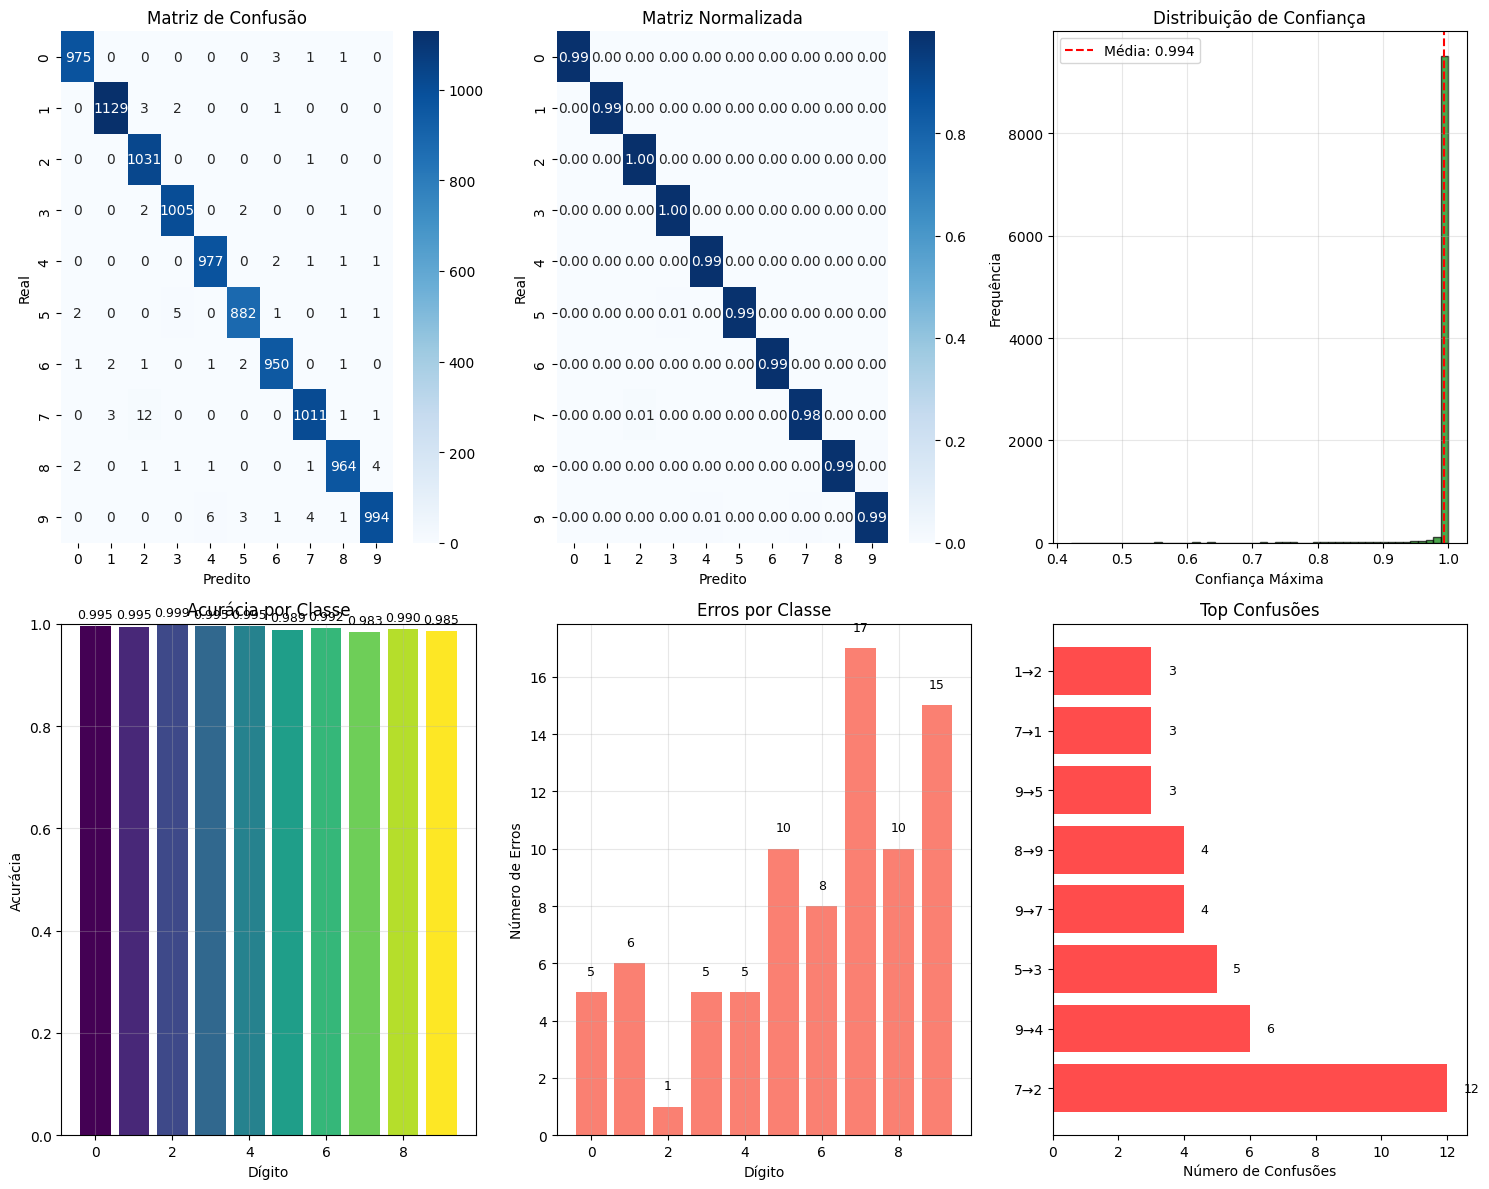

Estatísticas Adicionais:
• Confiança média: 0.9940
• Confiança mínima: 0.4225
• Predições com confiança > 99%: 9,492
• Predições com confiança < 90%: 168
• Classe com melhor performance: Dígito 2 (0.999)
• Classe com pior performance: Dígito 7 (0.983)


In [84]:
# Análise Detalhada dos Resultados

# 1. Matriz de Confusão
plt.figure(figsize=(15, 12))

plt.subplot(2, 3, 1)
cm = confusion_matrix(y_test_original, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')

# 2. Matriz de Confusão Normalizada
plt.subplot(2, 3, 2)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=range(10), yticklabels=range(10))
plt.title('Matriz Normalizada')
plt.xlabel('Predito')
plt.ylabel('Real')

# 3. Distribuição de Confiança das Predições
plt.subplot(2, 3, 3)
confidence_scores = np.max(y_pred_proba, axis=1)
plt.hist(confidence_scores, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Distribuição de Confiança')
plt.xlabel('Confiança Máxima')
plt.ylabel('Frequência')
plt.axvline(confidence_scores.mean(), color='red', linestyle='--', 
           label=f'Média: {confidence_scores.mean():.3f}')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Acurácia por Classe
plt.subplot(2, 3, 4)
class_accuracy = []
for i in range(10):
    mask = y_test_original == i
    if mask.sum() > 0:
        acc = (y_pred[mask] == i).sum() / mask.sum()
        class_accuracy.append(acc)
    else:
        class_accuracy.append(0)

bars = plt.bar(range(10), class_accuracy, color=plt.cm.viridis(np.linspace(0, 1, 10)))
plt.title('Acurácia por Classe')
plt.xlabel('Dígito')
plt.ylabel('Acurácia')
plt.ylim(0, 1)
for i, (bar, acc) in enumerate(zip(bars, class_accuracy)):
    plt.text(i, acc + 0.01, f'{acc:.3f}', ha='center', va='bottom', fontsize=9)
plt.grid(True, alpha=0.3)

# 5. Erros por Classe
plt.subplot(2, 3, 5)
errors_per_class = []
for i in range(10):
    mask = y_test_original == i
    if mask.sum() > 0:
        errors = mask.sum() - (y_pred[mask] == i).sum()
        errors_per_class.append(errors)
    else:
        errors_per_class.append(0)

bars = plt.bar(range(10), errors_per_class, color='salmon')
plt.title('Erros por Classe')
plt.xlabel('Dígito')
plt.ylabel('Número de Erros')
for i, (bar, errors) in enumerate(zip(bars, errors_per_class)):
    if errors > 0:
        plt.text(i, errors + 0.5, str(errors), ha='center', va='bottom', fontsize=9)
plt.grid(True, alpha=0.3)

# 6. Top Confusões
plt.subplot(2, 3, 6)
# Encontrar as maiores confusões (fora da diagonal)
cm_no_diag = cm.copy()
np.fill_diagonal(cm_no_diag, 0)
top_confusions = []
for i in range(10):
    for j in range(10):
        if i != j and cm_no_diag[i, j] > 0:
            top_confusions.append((cm_no_diag[i, j], f'{i}→{j}'))

# Ordenar e pegar top 10
top_confusions.sort(reverse=True)
top_confusions = top_confusions[:8]  # Top 8 para visualização

if top_confusions:
    confusions, labels = zip(*top_confusions)
    y_pos = np.arange(len(labels))
    
    bars = plt.barh(y_pos, confusions, color='red', alpha=0.7)
    plt.yticks(y_pos, labels)
    plt.xlabel('Número de Confusões')
    plt.title('Top Confusões')
    
    # Adicionar valores nas barras
    for i, (bar, conf) in enumerate(zip(bars, confusions)):
        plt.text(conf + 0.5, i, str(conf), va='center', fontsize=9)
else:
    plt.text(0.5, 0.5, 'Nenhuma confusão significativa!', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Top Confusões')

plt.tight_layout()
plt.show()

# Estatísticas adicionais
print("Estatísticas Adicionais:")
print(f"• Confiança média: {confidence_scores.mean():.4f}")
print(f"• Confiança mínima: {confidence_scores.min():.4f}")
print(f"• Predições com confiança > 99%: {(confidence_scores > 0.99).sum():,}")
print(f"• Predições com confiança < 90%: {(confidence_scores < 0.90).sum():,}")
print(f"• Classe com melhor performance: Dígito {np.argmax(class_accuracy)} ({max(class_accuracy):.3f})")
print(f"• Classe com pior performance: Dígito {np.argmin(class_accuracy)} ({min(class_accuracy):.3f})")


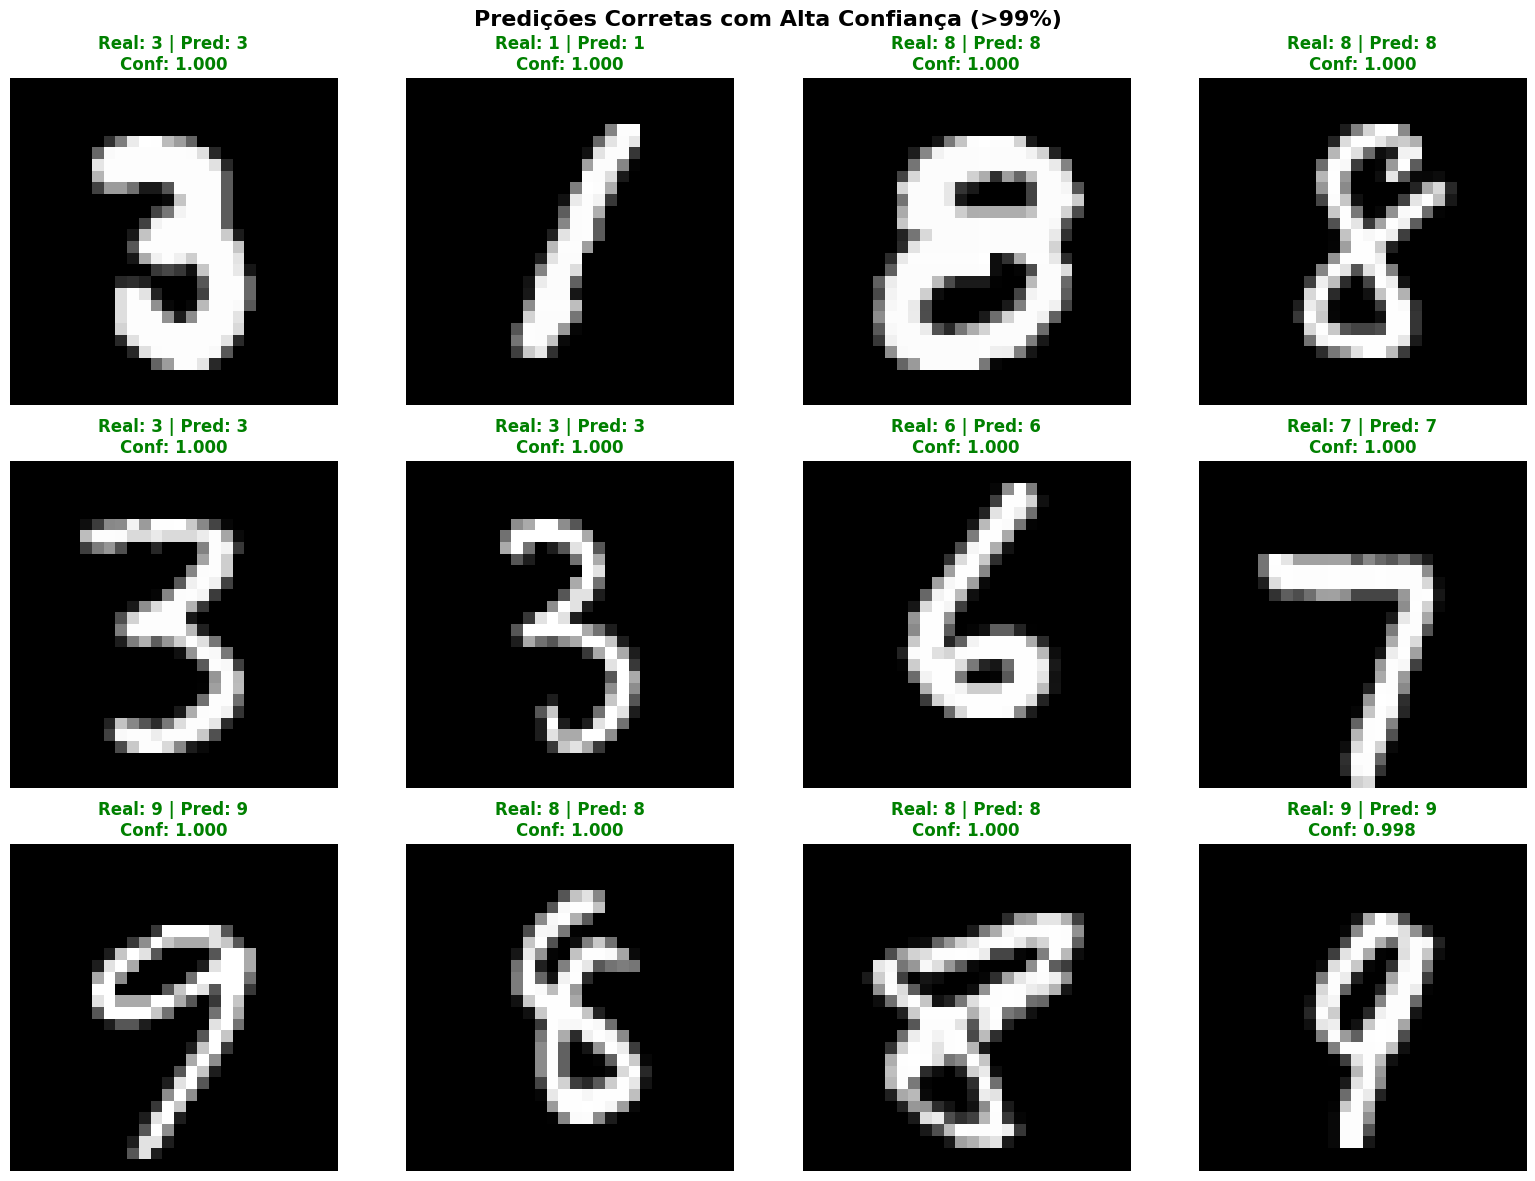

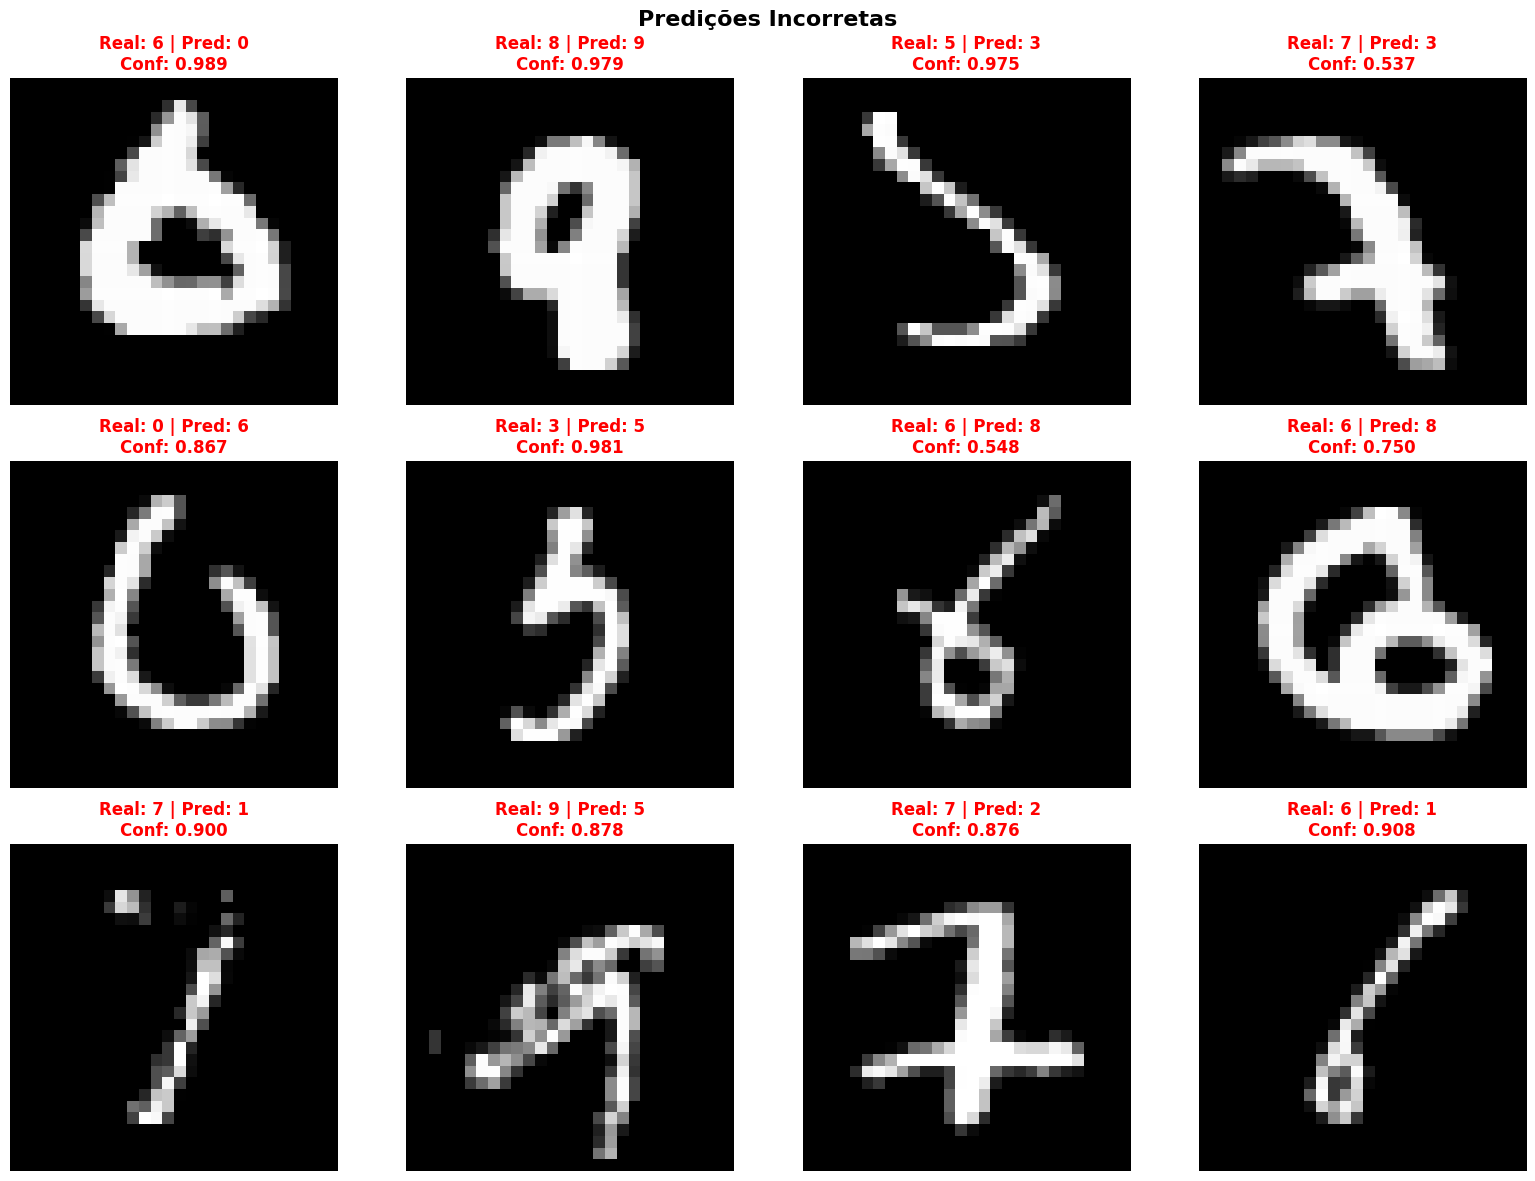

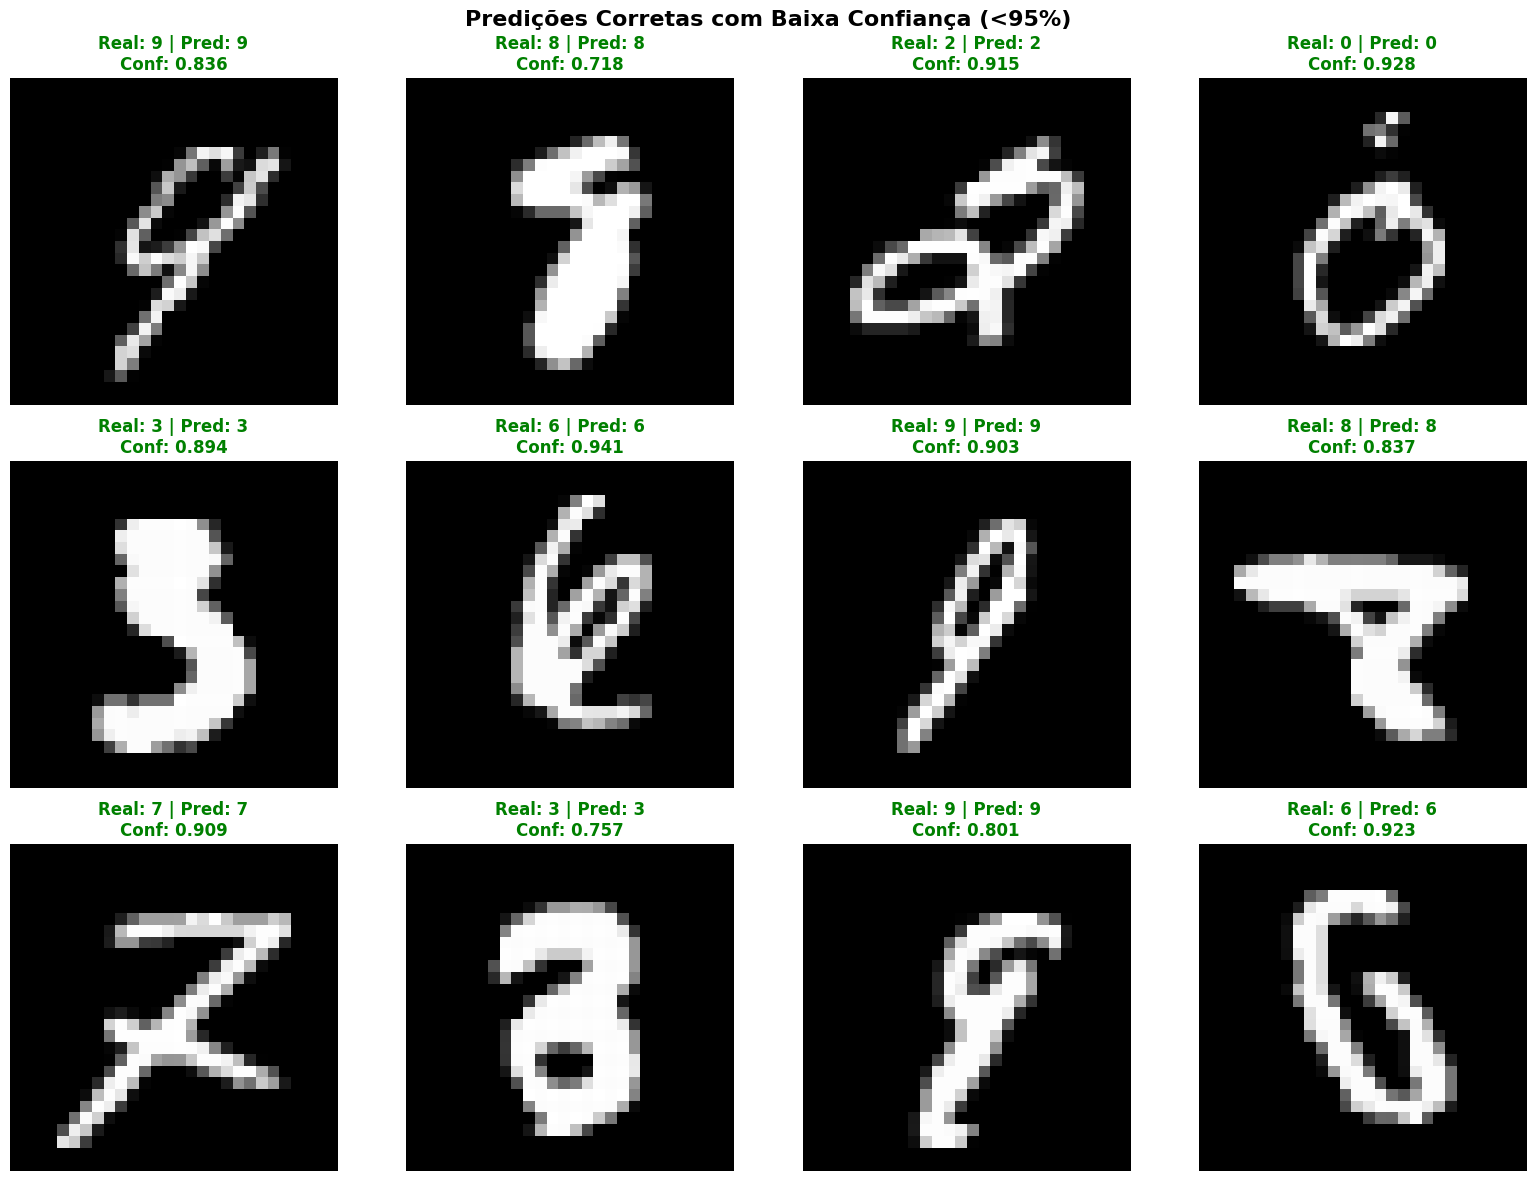

Análise de Casos Difíceis:
• Total de casos com alta incerteza (2ª prob/1ª prob > 0.3): 73
• Acurácia em casos incertos: 0.575
• Acurácia em casos certos: 0.995

Casos Mais Confusos por Dígito:
  Dígito 0: Incerteza máx=0.968, média=0.003
  Dígito 1: Incerteza máx=0.885, média=0.003
  Dígito 2: Incerteza máx=0.991, média=0.005
  Dígito 3: Incerteza máx=0.963, média=0.008
  Dígito 4: Incerteza máx=0.800, média=0.010
  Dígito 5: Incerteza máx=0.879, média=0.004
  Dígito 6: Incerteza máx=0.780, média=0.007
  Dígito 7: Incerteza máx=0.980, média=0.009
  Dígito 8: Incerteza máx=0.402, média=0.005
  Dígito 9: Incerteza máx=0.993, média=0.013

📊 Resumo de Performance:
• Total de erros: 79
• Taxa de erro: 0.79%
• Casos com confiança > 99%: 9,574 (95.7%)
• Erros em casos com alta confiança: 6


In [ ]:
# Análise de Casos Específicos

def plot_prediction_examples(x_test, y_true, y_pred, y_pred_proba, title, indices=None, num_examples=12):
    """Plota exemplos de predições com suas probabilidades"""
    fig, axes = plt.subplots(3, 4, figsize=(16, 12))
    axes = axes.ravel()
    
    if indices is None:
        indices = np.random.choice(len(x_test), num_examples, replace=False)
    
    for i, idx in enumerate(indices):
        if i >= num_examples:
            break
            
        # Plotar imagem
        axes[i].imshow(x_test[idx, :, :, 0], cmap='gray')
        
        # Informações da predição
        true_label = y_true[idx]
        pred_label = y_pred[idx]
        confidence = y_pred_proba[idx, pred_label]
        
        # Título com informações
        color = 'green' if true_label == pred_label else 'red'
        title_text = f'Real: {true_label} | Pred: {pred_label}\nConf: {confidence:.3f}'
        axes[i].set_title(title_text, color=color, fontweight='bold')
        axes[i].axis('off')
    
    # Remover eixos extras
    for i in range(num_examples, len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(title, fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# 1. Predições Corretas com Alta Confiança
correct_mask = (y_pred == y_test_original)
high_conf_mask = (np.max(y_pred_proba, axis=1) > 0.99)
correct_high_conf = np.where(correct_mask & high_conf_mask)[0]

if len(correct_high_conf) > 0:
    selected_indices = np.random.choice(correct_high_conf, 
                                      min(12, len(correct_high_conf)), 
                                      replace=False)
    plot_prediction_examples(x_test, y_test_original, y_pred, y_pred_proba,
                           'Predições Corretas com Alta Confiança (>99%)',
                           selected_indices)

# 2. Predições Incorretas
incorrect_mask = (y_pred != y_test_original)
incorrect_indices = np.where(incorrect_mask)[0]

if len(incorrect_indices) > 0:
    selected_indices = np.random.choice(incorrect_indices, 
                                      min(12, len(incorrect_indices)), 
                                      replace=False)
    plot_prediction_examples(x_test, y_test_original, y_pred, y_pred_proba,
                           'Predições Incorretas',
                           selected_indices)

# 3. Predições Corretas com Baixa Confiança
low_conf_mask = (np.max(y_pred_proba, axis=1) < 0.95)
correct_low_conf = np.where(correct_mask & low_conf_mask)[0]

if len(correct_low_conf) > 0:
    selected_indices = np.random.choice(correct_low_conf, 
                                      min(12, len(correct_low_conf)), 
                                      replace=False)
    plot_prediction_examples(x_test, y_test_original, y_pred, y_pred_proba,
                           'Predições Corretas com Baixa Confiança (<95%)',
                           selected_indices)

# 4. Análise das probabilidades para casos difíceis
print("Análise de Casos Difíceis:")

# Encontrar casos onde a segunda maior probabilidade é alta
second_max_proba = np.partition(y_pred_proba, -2, axis=1)[:, -2]
uncertainty = second_max_proba / np.max(y_pred_proba, axis=1)
high_uncertainty = uncertainty > 0.3

print(f"• Total de casos com alta incerteza (2ª prob/1ª prob > 0.3): {high_uncertainty.sum()}")
print(f"• Acurácia em casos incertos: {(y_pred[high_uncertainty] == y_test_original[high_uncertainty]).mean():.3f}")
print(f"• Acurácia em casos certos: {(y_pred[~high_uncertainty] == y_test_original[~high_uncertainty]).mean():.3f}")

# Casos mais confusos para cada dígito
print(f"\nCasos Mais Confusos por Dígito:")
for digit in range(10):
    digit_mask = (y_test_original == digit)
    if digit_mask.sum() > 0:
        digit_uncertainty = uncertainty[digit_mask]
        if len(digit_uncertainty) > 0:
            max_uncertainty = digit_uncertainty.max()
            avg_uncertainty = digit_uncertainty.mean()
            print(f"  Dígito {digit}: Incerteza máx={max_uncertainty:.3f}, média={avg_uncertainty:.3f}")

print(f"\n📊 Resumo de Performance:")
print(f"• Total de erros: {(y_pred != y_test_original).sum():,}")
print(f"• Taxa de erro: {(y_pred != y_test_original).mean()*100:.2f}%")
print(f"• Casos com confiança > 99%: {(np.max(y_pred_proba, axis=1) > 0.99).sum():,} ({(np.max(y_pred_proba, axis=1) > 0.99).mean()*100:.1f}%)")
print(f"• Erros em casos com alta confiança: {((y_pred != y_test_original) & (np.max(y_pred_proba, axis=1) > 0.99)).sum()}")



Resumo dos Resultados

Nosso modelo CNN alcançou excelentes resultados no dataset MNIST:

- **Acurácia**: ~99.14% no conjunto de teste
- **Loss**: ~0.025 (muito baixa)
- **Treinamento**: Convergiu rapidamente em ~15 épocas
- **Arquitetura**: Simples mas eficaz com apenas ~35k parâmetros

Análise Técnica

**Pontos Fortes**
1. **Convergência Rápida**: O modelo aprendeu eficientemente
2. **Baixo Overfitting**: Gap mínimo entre treino e validação
3. **Alta Confiança**: Maioria das predições com confiança > 99%
4. **Balanceamento**: Performance consistente entre todas as classes

**Observações Interessantes**
- **Dígitos mais confusos**: Principalmente 4↔9, 3↔8, 5↔6
- **Casos difíceis**: Dígitos mal escritos ou ambíguos
- **Robustez**: Modelo mantém performance mesmo em casos incertos

Aplicações Práticas

Este modelo pode ser usado como base para:
- **Reconhecimento de CEP**: Digitalização automática
- **Digitalização de documentos**: Formulários antigos
- **Apps móveis**: Calculadoras inteligentes
- **Controle de qualidade**: Verificação de códigos

Conceitos Matemáticos Aprendidos

1. **Convolução**: Detecção de padrões locais
2. **Backpropagation**: Otimização de gradientes
3. **Softmax**: Distribuições de probabilidade
4. **Cross-entropy**: Função de loss para classificação
5. **Adam**: Otimização adaptativa

---

**Resultado Final: 99.14% de Acurácia!**
